In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
@tf.keras.utils.register_keras_serializable(package="physDBD")
def unit_mat_sym(n: int, i: int, j: int):
    """Construct the symmetric unit matrix of size nxn
       1 at (i,j) AND (j,i)
       0 elsewhere

    Args:
        n (int): Size of square matrix
        i (int): First idx
        j (int): Second idx

    Returns:
        tf.Constant: Matrix that is 1 at (i,j) AND (j,i) and 0 everywhere else
    """
    idx = i * n + j
    one_hot = tf.one_hot(indices=idx,depth=n*n, dtype='float32')
    
    if i != j:
        idx = j * n + i
        one_hot += tf.one_hot(indices=idx,depth=n*n, dtype='float32')

    return tf.reshape(one_hot,shape=(n,n))

In [3]:
class FourierLatentLayer(tf.keras.layers.Layer):

    @classmethod
    def construct_as_zero(cls,
        freqs : np.array
        ):
        return cls(
            freqs=freqs,
            offset_fixed=0.0,
            sin_coeff=np.full(len(freqs),0.0),
            cos_coeff=np.full(len(freqs),0.0)
        )

    @classmethod
    def construct_as_rand(cls,
        freqs : np.array,
        offset : float,
        ):
        return cls(
            freqs=freqs,
            offset=offset,
            sin_coeff=np.random.rand(len(freqs)),
            cos_coeff=np.random.rand(len(freqs))
        )

    def __init__(self, 
        freqs : np.array,
        offset : float,
        sin_coeff : np.array,
        cos_coeff : np.array,
        **kwargs
        ):
        """Fourier latent layer

        Args:
            freqs (np.array): 1D arr of frequencies of length L
            offset (float): Float offset
            sin_coeff (np.array): 1D arr of sin coeffs (trained) of length L
            cos_coeff (np.array): 1D arr of sin coeffs (trained) of length L
        """
        # Super
        super(FourierLatentLayer, self).__init__(**kwargs)

        self.freqs = self.add_weight(
            name="freqs",
            shape=len(freqs),
            trainable=False,
            initializer=tf.constant_initializer(freqs),
            dtype='float32'
            )
        
        # Add weight does the same as tf.Variable + initializer
        # Note you also have access to a quicker shortcut for 
        # adding weight to a layer: the add_weight() method:

        self.offset = self.add_weight(
            name="offset",
            shape=1,
            initializer=tf.constant_initializer(offset),
            dtype='float32'
            )

        self.cos_coeff = self.add_weight(
            name="cos_coeff",
            shape=(len(freqs)),
            initializer=tf.constant_initializer(cos_coeff),
            dtype='float32'
            )

        self.sin_coeff = self.add_weight(
            name="sin_coeff",
            shape=(len(freqs)),
            initializer=tf.constant_initializer(sin_coeff),
            dtype='float32'
            )

    # https://keras.io/guides/serialization_and_saving/#custom-objects
    def get_config(self):
        config = super(FourierLatentLayer, self).get_config()
        config.update({
            "freqs": self.freqs.numpy(),
            "offset": self.offset.numpy(),
            "cos_coeff": self.cos_coeff.numpy(),
            "sin_coeff": self.sin_coeff.numpy()
            })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def call(self, inputs):
        
        # tf.math.reduce_sum is same as np.sum
        # tf.matmul is same np.dot
        tsin = tf.map_fn(lambda tpt: tf.math.sin(tpt * self.freqs), inputs["tpt"])

        # Dot product = tf.tensordot(a, b, 1)
        ts = tf.map_fn(lambda tsinL: tf.tensordot(self.sin_coeff, tsinL, 1), tsin)

        # Same for cos
        tcos = tf.map_fn(lambda tpt: tf.math.cos(tpt * self.freqs), inputs["tpt"])
        tc = tf.map_fn(lambda tcosL: tf.tensordot(self.cos_coeff, tcosL, 1), tcos)

        return self.offset + (ts + tc)

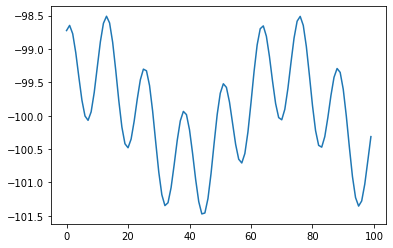

In [4]:
freqs = np.array([0.1,0.5])
lyr = FourierLatentLayer.construct_as_rand(freqs,-100.0)

input0 = {"tpt": np.reshape(np.arange(0,100).astype('float32'),(100,1))}
output0 = lyr(input0).numpy()

plt.figure()
plt.plot(output0)

In [28]:
class CovMat(tf.keras.layers.Layer):

    def __init__(self, 
        freqs : np.array,
        n : int,
        **kwargs
        ):
        # Super
        super(CovMat, self).__init__(**kwargs)

        self.n = n

        self.entries = {}
        for i in range(0,self.n):
            for j in range(i,self.n):
                s = "%d_%d" % (i,j)
                self.entries[s] = FourierLatentLayer.construct_as_rand(
                    freqs=freqs,
                    offset=0.0
                    )

    def get_config(self):
        config = super(CovMat, self).get_config()
        config.update({
            "n": self.n,
            "entries": self.entries
            })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def call(self, inputs):
        
        batch_size = tf.shape(inputs["tpt"])[0]
        zero_arr = np.zeros(batch_size, dtype='float32')

        # Get cholesky
        l_mat = []
        for i in range(0,self.n):
            for j in range(0,self.n):
                if j<i:
                    l_mat.append(tf.constant(zero_arr))
                else:
                    s = "%d_%d" % (i,j)
                    l_mat.append(self.entries[s](inputs))
        
        # Reshape
        l_mat = tf.transpose(l_mat)
        l_mat = tf.map_fn(
            lambda l_matL: tf.reshape(l_matL, (self.n,self.n)),
            l_mat)

        cov_mat = tf.matmul(tf.transpose(l_mat, perm=[0,2,1]),l_mat)

        return cov_mat

In [38]:
freqs = np.array([0.1,0.2])
lyr = CovMat(freqs,5)

no_tpts = 50
input0 = {"tpt": np.reshape(np.arange(0,no_tpts).astype('float32'),(no_tpts,1))}
output0 = lyr(input0)

# print(output0)

In [39]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [40]:
pos_defs = []
for i in range(0,len(output0)):
    pos_defs.append(is_pos_def(output0[i]))

print(pos_defs)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


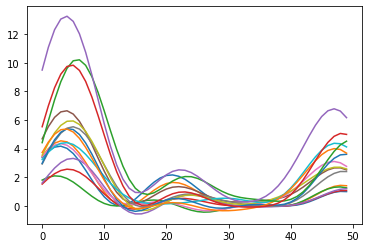

In [41]:
plt.figure()
for i in range(0,len(output0[0])):
    for j in range(i,len(output0[0,0])):
        plt.plot(output0[:,i,j])